# Poromechanics
In this tutorial we will run a multiphysics simulation consisting of fully coupled single phase flow and mechanics.

In the [single phase flow tutorial](./single_phase_flow.ipynb), we introduced 
the concept of constructing a simulation model from several mixin classes using 
multiple inheritance in Python.
This approach allows us to keep the code modular and reuse some of the mixins in newly
defined models.

The benefits of this approach become clear when we want to define a multiphysics
model. To achieve that, it is usually enough to combine existing mixins properly.
We will illustrate that by assembling a poromechanics model from the mixins designed 
separately for the single phase flow model and the mechanics model. 

For this, we will first define two single-physics models: one for mechanics and one for single phase flow. Then, we will combine them into one poromechanics model. 

Note that there is already a poromechanics model in PorePy, so what we demonstrate here in this tutorial is not building the entire model from scratch.
It is rather modifying two single-physics models, and then combining them to modify the coupled model.

# Mechanics model

Here, we will run the single-physics problem of solid elasticity without any flow.
The mathematical formulation of this problem in the porous matrix is:

$$ \nabla \cdot \sigma + F = 0 $$
$$ \sigma = C : \frac{1}{2} (\nabla u + (\nabla u)^T ) $$

where $F$ is the body force, $\sigma$ is the stress tensor, $C$ is the 4th order tensor 
and $u$ is the displacement.
The fracture deformation equation can be found in the article [Berge et al. 2019](https://onlinelibrary.wiley.com/doi/full/10.1002/nme.6238). 
Note that in the code, we use a nondimensionalized contact traction variable for the fracture deformation.

In the example problem, we apply the zero Dirichlet boundary condition to each boundary.
This boundary condition is provided by default in the base model class, so we will not
modify it. Now, we will define a mixin to add a body force to some cells in the center
of the model:

In [1]:
import porepy as pp
import numpy as np


class BodyForceMixin:
    nd: int
    """Ambient dimension."""

    units: pp.Units

    solid: pp.SolidConstants

    def body_force(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        units = self.units
        vals = []
        for sd in subdomains:
            data = np.zeros((sd.num_cells, self.nd))

            # We add the source only to the 2D domain and not the fracture.
            if sd.dim == 2:
                # Selecting central cells
                cell_centers = sd.cell_centers
                indices = (
                    (cell_centers[0] > (0.3 / units.m))
                    & (cell_centers[0] < (0.7 / units.m))
                    & (cell_centers[1] > (0.3 / units.m))
                    & (cell_centers[1] < (0.7 / units.m))
                )

                acceleration = self.units.convert_units(-9.8, "m * s^-2")
                force = self.solid.density * acceleration
                data[indices, 1] = force * sd.cell_volumes[indices]

            vals.append(data)
        return pp.ad.DenseArray(np.concatenate(vals).ravel(), "body_force")

Now we can combine our mixin with the standard model `MomentumBalance`. This time we will not define the geometry manually, but instead use one of the pre-defined geometries provided by a mixin class.

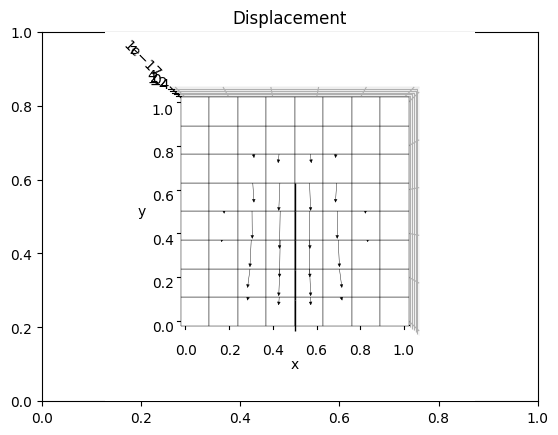

In [2]:
from porepy.applications.md_grids.model_geometries import (
    SquareDomainOrthogonalFractures,
)


class MomentumBalanceGeometryBC(
    BodyForceMixin,
    SquareDomainOrthogonalFractures,
    pp.MomentumBalance,
):
    """Adding geometry and modified boundary conditions to the default model."""

    def meshing_arguments(self) -> dict:
        cell_size = self.units.convert_units(0.125, "m")
        return {"cell_size": cell_size}


model = MomentumBalanceGeometryBC()
pp.run_time_dependent_model(model)
pp.plot_grid(
    model.mdg,
    vector_value=model.displacement_variable,
    rgb=[1, 1, 1],
    figsize=(10, 8),
    linewidth=0.3,
    title="Displacement",
)

# Single phase flow model

We have seen how to modify boundary condition and source for the single phase flow model
in the [earlier tutorial](./single_phase_flow.ipynb).
For this example we will repeat this process by setting the boundary condition:
* Zero Dirichlet on the north boundary
* Zero Neumann (no flux) everywhere else

And we will again set the fracture inlet source.

In [ ]:
class PressureSourceBC:
    def bc_type_darcy_flux(self, sd: pp.Grid) -> pp.BoundaryCondition:
        """Assign Dirichlet boundary condition to the north boundary and Neumann
        everywhere else.

        """
        domain_sides = self.domain_boundary_sides(sd)
        bc = pp.BoundaryCondition(sd, domain_sides.north, "dir")
        return bc

    def fluid_source(self, subdomains: list[pp.Grid]) -> pp.ad.Operator:
        """Assign fracture source."""
        # Retrieve internal sources (jump in mortar fluxes) from the base class
        internal_sources: pp.ad.Operator = super().fluid_source(subdomains)

        # Retrieve external (integrated) sources from the exact solution.
        values = []
        src_value: float = self.units.convert_units(0.1, "kg * m^-3 * s^-1")
        for sd in subdomains:
            if sd.dim == self.mdg.dim_max():
                values.append(np.zeros(sd.num_cells))
            else:
                values.append(np.ones(sd.num_cells) * src_value)

        external_sources = pp.wrap_as_dense_ad_array(np.concatenate(values))

        # Add up both contributions
        source = internal_sources + external_sources
        source.set_name("fluid sources")

        return source

Again, we combine our mixin with the standard model and using the standard mixin geometry:

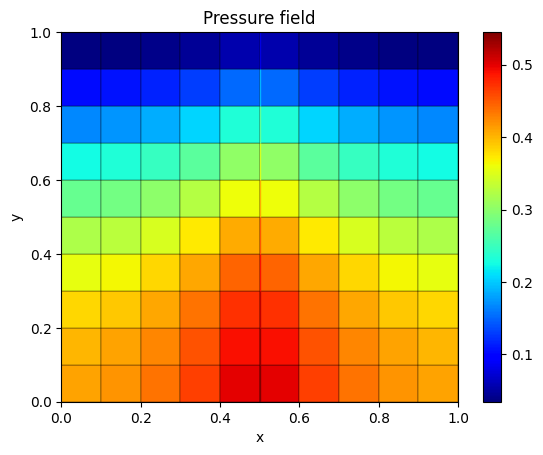

In [ ]:
class PoromechanicsSourceBC(
    PressureSourceBC,
    SquareDomainOrthogonalFractures,
    pp.SinglePhaseFlow,
):
    """Adding geometry, boundary conditions and source to the default model."""

    def meshing_arguments(self) -> dict:
        cell_size = self.units.convert_units(0.1, "m")
        return {"cell_size": cell_size}


model = PoromechanicsSourceBC()
pp.run_time_dependent_model(model)
pp.plot_grid(
    model.mdg,
    cell_value=model.pressure_variable,
    figsize=(10, 8),
    linewidth=0.25,
    title="Pressure field",
    plot_2d=True,
)

# Poromechanics

Now we are ready to combine the mixins to define a poromechanics problem that is different from the default one.
The modified poromechanics model takes the mechanics body source from the mechanics problem.
From the flow problem it will inherit the flow boundary condition and source term.

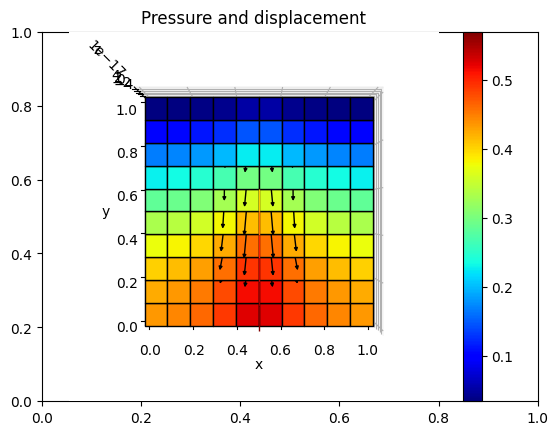

In [ ]:
class PoromechanicsSourceBC(
    PressureSourceBC,
    BodyForceMixin,
    SquareDomainOrthogonalFractures,
    pp.Poromechanics,
):
    """Adding geometry, boundary conditions and source to the default model."""

    def meshing_arguments(self) -> dict:
        cell_size = self.units.convert_units(0.1, "m")
        return {"cell_size": cell_size}


model = PoromechanicsSourceBC()
pp.run_time_dependent_model(model)
pp.plot_grid(
    model.mdg,
    cell_value=model.pressure_variable,
    vector_value=model.displacement_variable,
    figsize=(10, 8),
    title="Pressure and displacement",
)

You may notice that the base class `Poromechanics` is defined by combining several mixins:

In [6]:
import inspect


print(inspect.getsource(pp.Poromechanics))

class Poromechanics(  # type: ignore[misc]
    EquationsPoromechanics,
    VariablesPoromechanics,
    ConstitutiveLawsPoromechanics,
    BoundaryConditionsPoromechanics,
    SolutionStrategyPoromechanics,
    pp.FluidMixin,
    pp.ModelGeometry,
    pp.DataSavingMixin,
):
    """Class for the coupling of mass and momentum balance in a mixed-dimensional porous
    medium.

    """



Each of these mixins is a combination of the flow and the mechanics mixins. For instance:

In [7]:
from porepy.models.poromechanics import EquationsPoromechanics


print(inspect.getsource(EquationsPoromechanics))

class EquationsPoromechanics(
    mass.MassBalanceEquations,
    momentum.MomentumBalanceEquations,
):
    """Combines mass and momentum balance equations."""

    def set_equations(self):
        """Set the equations for the poromechanics problem.

        Call both parent classes' set_equations methods.

        """
        mass.MassBalanceEquations.set_equations(self)
        momentum.MomentumBalanceEquations.set_equations(self)



Thereby, the philosophy of multiple inheritance and mixins helps to modularize and reuse
 a significant part of code.

# Multiphysics convergence checks
In subsurface poromechanics, fluid pressures and solid displacements often operate on widely different scales, making it critical to respect the norms of each physical field. Ignoring these differences can lead to numerical instability and inaccurate coupling, distorting the true behavior of the system, as one physics may dominate the other. To respect each single physics during convergence checks, we recommend activating `MultiphysicsNorms` which will use a decoupled approach during the convergence check. For this, one has to enhance the model mixin with the appropriate class. The tolerances `nl_convergence_tol` and `nl_convergence_tol_res` control the convergence check separately for the increments and residuals. Both are meant in a relative sense, and both checks need to be satisfied in order for identifying convergence.

In the following, we display the use of multiphysics norms and discuss the difference to the standard case.

C:\Users\jbo062\src\porepy\src\porepy\models\solution_strategy.py:858: UserWarning: PyPardiso could not be imported,
                    falling back on scipy.sparse.linalg.spsolve
  warnings.warn(


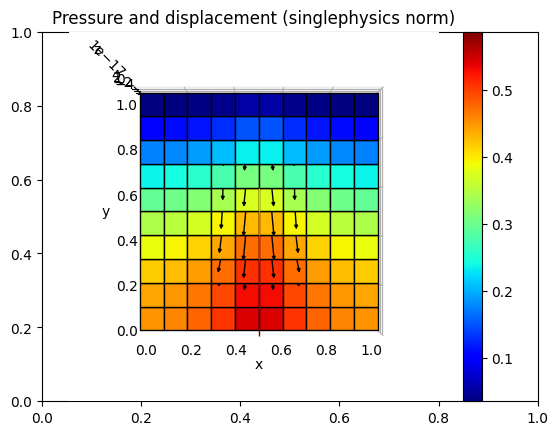

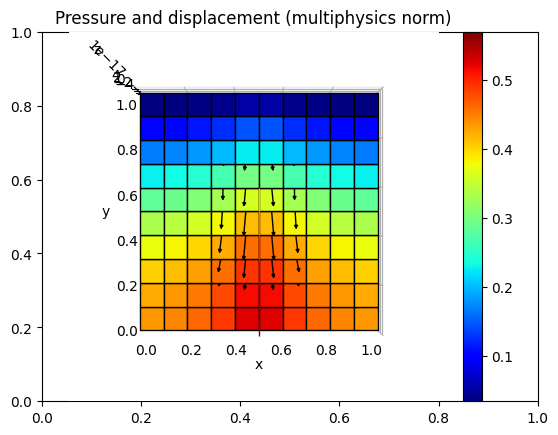

In [ ]:
class PoromechanicsSourceBCwithMultiphysicsConvergenceCheck(
    pp.models.solution_strategy.MultiphysicsNorms,
    PoromechanicsSourceBC
):
    """Adding multiphysics norms to the custom poromechanics model."""
    ...

# Let's use quite loose convergence tolerances to illustrate the multiphysics norms.
solver_params = {
    "nl_convergence_tol": 1e-2, # Controls the tolerance of the norm of the separate increments
    "nl_convergence_tol_res": 1e-2, # Controls the tolerance of the norm of the separate residuals
}

# Rerun original model with provided solver parameters.
model = PoromechanicsSourceBC()
pp.run_time_dependent_model(model, solver_params)

# Run the model with multiphysics convergence check.
model_with_multiphysics_convergence_check = PoromechanicsSourceBCwithMultiphysicsConvergenceCheck()
pp.run_time_dependent_model(model_with_multiphysics_convergence_check, solver_params)

# In the eye-norm the solutions look the same.
pp.plot_grid(
    model.mdg,
    cell_value=model.pressure_variable,
    vector_value=model.displacement_variable,
    figsize=(10, 8),
    title="Pressure and displacement (singlephysics norm)",
)

pp.plot_grid(
    model_with_multiphysics_convergence_check.mdg,
    cell_value=model_with_multiphysics_convergence_check.pressure_variable,
    vector_value=model_with_multiphysics_convergence_check.displacement_variable,
    figsize=(10, 8),
    title="Pressure and displacement (multiphysics norm)",
)

Let's compare some of the solver statistics, e.g., number of required nonlinear iterations. When using single-physics norms, the convergence criterion is met early on, while when respecting the multi-physics character, some additional iterations are needed.

In [ ]:
# Compare the number of iterations for the two models
print(f"Number of iterations (original model): {model.nonlinear_solver_statistics.num_iteration}")
print(f"Number of iterations (tailored criteria): {model_with_multiphysics_convergence_check.nonlinear_solver_statistics.num_iteration}")

Number of iterations (original model): 9
Number of iterations (tailored criteria): 2


A closer look at the norms of the single residuals of the different subphysics give more insight into how the different simulations terminated the nonlinear solver loop. For this, we utilize the `MultiphysicsNorms` to compute the residual at converged states for both models to obtain a fair comparison.

In [ ]:
# Let's compare e.g. the norms of the single-physics residuals of the separate models.
residual_norms = pp.models.solution_strategy.MultiphysicsNorms.compute_residual_norm(model, [])
residual_norms_with_multiphysics = model_with_multiphysics_convergence_check.compute_residual_norm([])
print(f"Norms of the single-physics residuals (original model):\n{residual_norms}\n")
print(f"Norms of the single-physics residuals (tailored criteria):\n{residual_norms_with_multiphysics}")

Norms of the single-physics residuals (original model):
{'normal_fracture_deformation_equation': np.float64(0.0), 'tangential_fracture_deformation_equation': np.float64(0.0), 'mass_balance_equation': np.float64(0.020057248698734802), 'interface_darcy_flux_equation': np.float64(0.001969800839758716), 'well_flux_equation': np.float64(0.0), 'momentum_balance_equation': np.float64(5.339289990847308e-16), 'interface_force_balance_equation': np.float64(1.728987171558284e-16)}

Norms of the single-physics residuals (tailored criteria):
{'normal_fracture_deformation_equation': np.float64(0.0), 'tangential_fracture_deformation_equation': np.float64(0.0), 'mass_balance_equation': np.float64(0.019403064678804836), 'interface_darcy_flux_equation': np.float64(1.288703224320436e-07), 'well_flux_equation': np.float64(0.0), 'momentum_balance_equation': np.float64(4.689880072099838e-16), 'interface_force_balance_equation': np.float64(1.1012422702461405e-16)}


To interpret the computed norms at converged state, we see that residual in the mass balance equation is quite comparable, while the interface darcy flux equation differs in several orders of magnitude. While the convergence check which is based on the single-physics norm combining all subphysics is quickly dominated by the convergence of the largest residual (here the mass balance equation), it does not pay attention to whether other subphysics/equations have converged in any sense. In contrast, the multiphysics norm does not accept the approximation after 2 iterations, as the darcy flux equation has not yet sufficiently reduced its residual compared to the initial residual. By splitting into the different subphysics, it is more agnostic to different characteristic scalings of the single subphysics. For this, the convergence check in `MultiphysicsNorms` is using the notion of relative errors.

# What we have explored
We set up and ran a poromechanics simulation using the body force and source mixin classes originally designed for uncoupled problems.